# Машинное обучение, DS-поток, осень 2022
## Задание 3.9


**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.


**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.

**Баллы за задание:**

* Задача 1 &mdash; 30 баллов;
* Задача 2 &mdash; 60 баллов;
* Задача 3 &mdash; 70 баллов + бонусные баллы + конфеты + декоративные фигурки.


---

### Задача 1

Рассмотрим данные из задачи 3.8.2. Задача заключается в сравнении моделей градиентного бустинга из sklearn, для которой категориальные признаки закодированы с помощью
* LabelEncoding,
* MeanEncoding.

Какие признаки будете рассматривать? Какие именно преобразования будете совершать?

In [779]:
import warnings
from collections import Counter

import numpy as np
import pandas as pd
import scipy.stats as sps
import seaborn as sns
sns.set(context='poster')

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import sklearn.metrics
from sklearn.datasets import load_boston
from sklearn.model_selection import KFold
from sklearn.metrics import (
    confusion_matrix, mean_squared_error, roc_auc_score
)
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import lightgbm as lgb

import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, DMatrix

from catboost import CatBoostRegressor, Pool, CatBoostClassifier

import math

warnings.filterwarnings('ignore')

In [911]:
data_train = pd.read_csv('houses_train.csv', parse_dates=[1])
data_test = pd.read_csv('houses_test.csv', parse_dates=[1])

Выполните базовую предобработку данных из задачи 3.8.2

*Совет.* Используйте код из своего решения предыдущего домашнего задания и/или код с семинаров.

In [912]:
data_train['month'] = data_train['date'].apply(lambda x: x.month)
data_test['month'] = data_test['date'].apply(lambda x: x.month)

In [913]:
data_train['date'] = data_train['date'].apply(lambda x: x.year)
data_test['date'] = data_test['date'].apply(lambda x: x.year)

In [914]:
data_train['timef_built'] = data_train['date'] - data_train['yr_built']

data_train['yr_renovated'] = list(map(lambda x: data_train['yr_built'][x] if data_train['yr_renovated'][x] == 0 \
                                      else data_train['yr_renovated'][x], np.arange(0, len(data_train['date']))))
data_train['timef_renovated'] = data_train['date'] - data_train['yr_renovated']

In [915]:
data_test['timef_built'] = data_test['date'] - data_test['yr_built']

data_test['yr_renovated'] = list(map(lambda x: data_test['yr_built'][x] if data_test['yr_renovated'][x] == 0 \
                                      else data_test['yr_renovated'][x], np.arange(0, len(data_test['date']))))
data_test['timef_renovated'] = data_test['date'] - data_test['yr_renovated']

In [916]:
train_names = ['timef_built', 'timef_renovated', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 
            'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'zipcode', 'month']
test_name = 'price'

In [917]:
X_train, X_test, y_train, y_test = train_test_split(data_train[train_names], data_train[test_name],
                                                    test_size=0.25, random_state=45)

In [918]:
X_test_start = data_test[train_names]
cat_features = ['zipcode', 'waterfront'] # категориальные признаки

In [919]:
X_train_origin = X_train.copy()
X_test_origin = X_test.copy()
#X_test_start_origin = X_test_start.copy()

Выполните обработку категориальных признаков

Для LabelEncoding:

In [920]:
X_train_label = X_train.copy()
X_test_label = X_test.copy()
#X_test_start_label = X_test_start.copy()

In [921]:
X_train_label[cat_features] = X_train_label[cat_features].astype(object)
X_test_label[cat_features] = X_test_label[cat_features].astype(object)
#X_test_start_label[cat_features] = X_test_start_label[cat_features].astype(object)

In [922]:
encoder = LabelEncoder()
for feature in cat_features:
    X_train_label[feature] = encoder.fit_transform(X_train_label[feature])
    X_test_label[feature] = encoder.transform(X_test_label[feature])
    #X_test_start_label[feature] = encoder.transform(X_test_start_label[feature])

Для MeanEncoding:

In [923]:
X_train_enc = X_train.copy()
X_test_enc = X_test.copy()
#X_test_start_enc = X_test_start.copy()

In [924]:
X_train_enc[cat_features] = X_train_enc[cat_features].astype(object)
X_test_enc[cat_features] = X_test_enc[cat_features].astype(object)
#X_test_start_enc[cat_features] = X_test_start_enc[cat_features].astype(object)

In [925]:
encoder_mean = TargetEncoder(cols=cat_features)
X_train_enc = encoder_mean.fit_transform(X_train_enc, y_train)
X_test_enc = encoder_mean.transform(X_test)
#X_test_start_enc = encoder_mean.transform(X_test_start_enc)

Обучим градиентный бустинг и сравним ошибки при двух разных подходах.

LabelEncoding:

In [496]:
n_estimators = 300
model_gd_label = GradientBoostingRegressor(n_estimators=n_estimators, random_state=25)
model_gd_label.fit(X_train_label, y_train)

GradientBoostingRegressor(n_estimators=300, random_state=25)

MeanEncoding:

In [500]:
n_estimators = 300
model_gd_enc = GradientBoostingRegressor(n_estimators=n_estimators, random_state=25)
model_gd_enc.fit(X_train_enc, y_train)

GradientBoostingRegressor(n_estimators=300, random_state=25)

Обучите модели и постройте зависимость значения MAPE от количества деревьев и их максимальной глубины.

In [501]:
mape_label = mean_absolute_percentage_error(y_test, model_gd_label.predict(X_test_label))
print('MAPE при LabelEncoding:', mape_label)

MAPE при LabelEncoding: 0.1339176939867255


In [502]:
mape_enc = mean_absolute_percentage_error(y_test, model_gd_enc.predict(X_test_enc))
print('MAPE при MeanEncoding:', mape_enc)

MAPE при MeanEncoding: 0.1281786796891129


Видим, что ошибка при MeanEncoding получилась меньше, что и логично, так как это более 'сильный' подход обработки категориальных признаков. Построим графики зависимости MAPE.

In [503]:
max_depth = 5 # зафиксируем максимальную глубину
learning_rate = 0.15 # зафиксируем размер шага метода оптимизации
n_estimators = 400

model_label = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
model_label.fit(X_train_label, y_train)

model_enc = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
model_enc.fit(X_train_enc, y_train)

GradientBoostingRegressor(learning_rate=0.15, max_depth=5, n_estimators=400)

In [504]:
mape_values_label = []
mape_values_enc = []
predictions_label = model_label.staged_predict(X_test_label)
predictions_enc = model_enc.staged_predict(X_test_enc)

for predicts_label, predicts_enc in zip(predictions_label, predictions_enc):
    mape_values_label.append(mean_absolute_percentage_error(y_test, predicts_label))
    mape_values_enc.append(mean_absolute_percentage_error(y_test, predicts_enc))

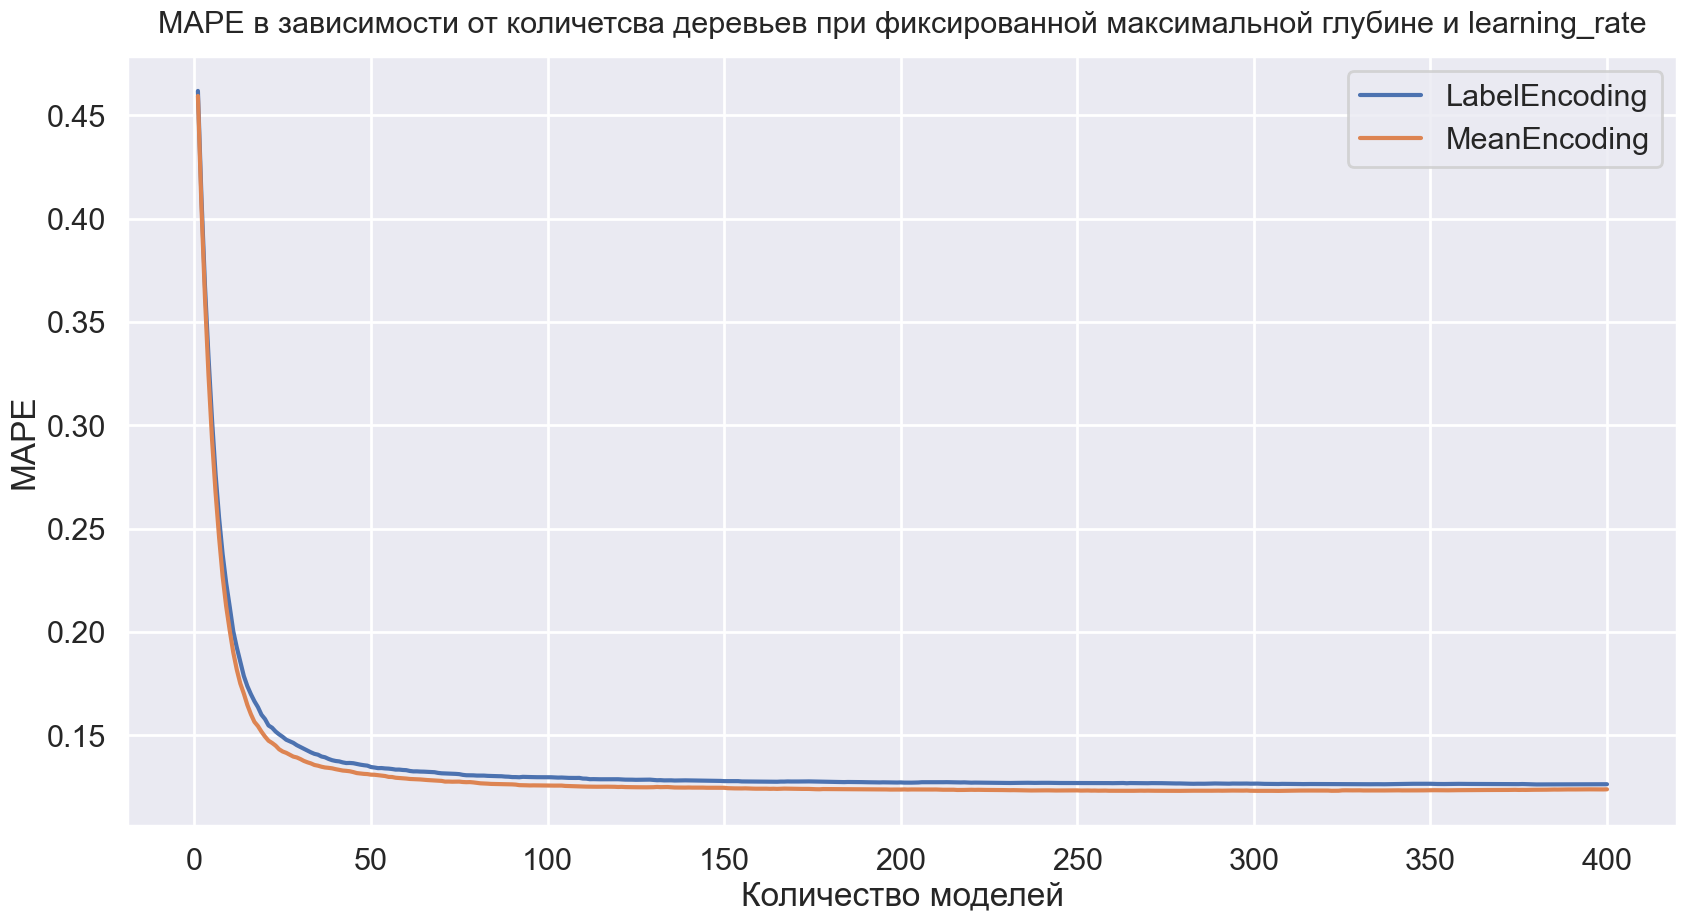

In [505]:
plt.figure(figsize=(20, 10))
plt.plot(np.arange(n_estimators) + 1, mape_values_label, label='LabelEncoding')
plt.plot(np.arange(n_estimators) + 1, mape_values_enc, label='MeanEncoding')
plt.legend()
plt.xlabel('Количество моделей')
plt.ylabel('MAPE')
plt.title('MAPE в зависимости от количетсва деревьев при фиксированной максимальной глубине и learning_rate', fontsize=22, y=1.02);

In [506]:
n_estimators = 200 # зафиксируем количество моделей
learning_rate = 0.15 # зафиксируем размер шага метода оптимизации
max_depth = np.arange(2, 16)
mape_label_depth = []
mape_enc_depth = []

for depth in tqdm(max_depth):
    model_label_depth = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=depth, learning_rate=learning_rate,
                                     random_state=25)
    model_label_depth.fit(X_train_label, y_train)
    
    model_enc_depth = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=depth, learning_rate=learning_rate,
                                     random_state=25)
    model_enc_depth.fit(X_train_enc, y_train)
    
    mape_label_depth.append(mean_absolute_percentage_error(y_test, model_label_depth.predict(X_test_label)))
    mape_enc_depth.append(mean_absolute_percentage_error(y_test, model_enc_depth.predict(X_test_enc)))

  0%|          | 0/14 [00:00<?, ?it/s]

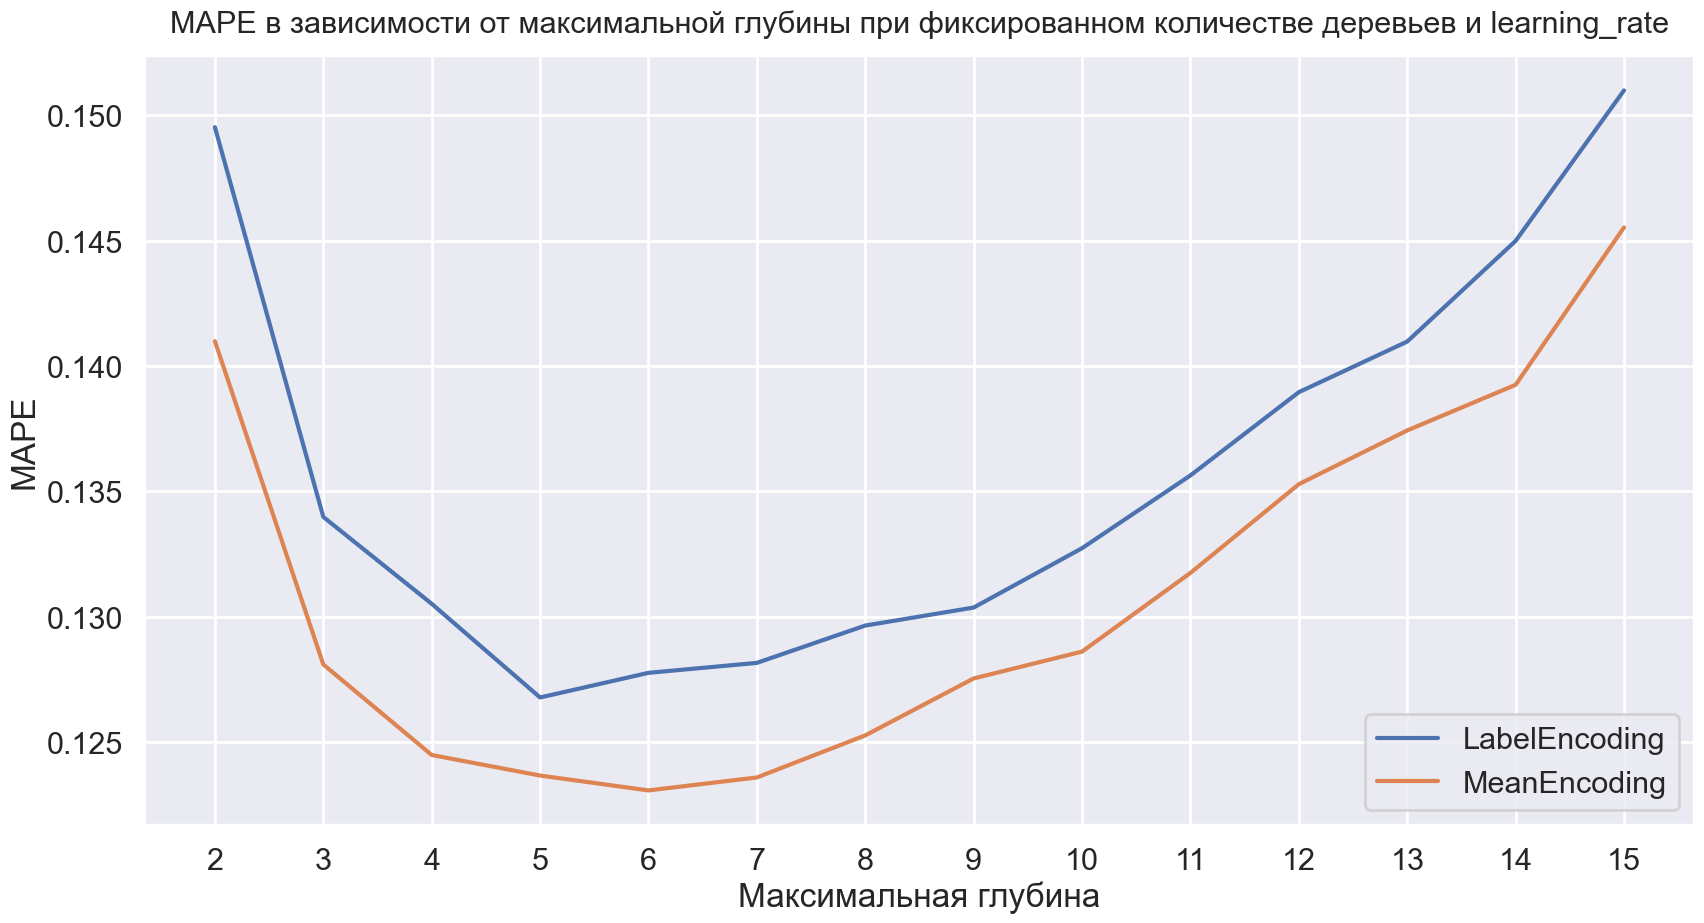

In [507]:
plt.figure(figsize=(20, 10))
plt.plot(max_depth, mape_label_depth, label='LabelEncoding')
plt.plot(max_depth, mape_enc_depth, label='MeanEncoding')
plt.legend()
plt.xticks(max_depth)
plt.xlabel('Максимальная глубина')
plt.ylabel('MAPE')
plt.title('MAPE в зависимости от максимальной глубины при фиксированном количестве деревьев и learning_rate', fontsize=22, y=1.02);

**Выводы:** В обоих графиках: и в зависимости от количества деревьев, и в зависимости от глубины деревьев MeanEncoding показывает меньшую ошибку, чем LabelEncoding. Как и раньше начиная с какого то момента на графике от количества дереьев ошибка почти не уменьшается, а на графике от глубины ошибка сначала достигает своего оптимума , а затем снова растет.

---

### Задача 2

Возьмите свое решение задачи 3.8.3. Если его нет, то решение задачи 3.8.2.

Задача состоит в том, чтобы попробовать улучшить предсказание вашей модели с помощью извлечения различных признаков с использованием кластеризации объектов. 

*Примечание.* Если предлагаемые преобразования уже были в вашем решении, в этой задаче обучите аналогичную модель без данных преобразований и сравните результаты с исходной моделью.

Общая схема следующая:
* кластеризация всех объектов на несколько кластеров, например, используя только широту и долготу;
* создание новых признаков &mdash; расстояние от объекта до центра кластера, а также средних характеристик по кластерам, например, количество комнат в квартире в среднем по кластеру;
* обучение модели с добавлением новых признаков.

Прежде чем приступить к выполнению, ответьте на следующие вопросы из логических соображений.
* Какой метод кластеризации стоит использовать и почему?
* Имеет ли смысл выполнять кластеризацию по другим признакам, помимо широты и долготы?
* Какие новые признаки добавить?
* Как могут повлиять новые признаки на конкретно вашу модель?

Стоит использовать метод k-means, так как для того, чтобы DBSCAN хорошо отработал данные должны быть примерно одной плотности, и подбирать его гиперпараметры довольно затруднительная задача. Иерархический же метод довольно дорогостоящий, он чувствителен к шуму и выбросам и может получиться так, что анализ дендрограммы будет провести очень сложно. Мне кажется выполнять кластеризации по другим признакам не принесет особого улучшения (по край ней мере не будет лучше данной кластеризации, так как здесь у нас есть широта и долгота, которые действительно как то описывают пространство). Добавим расстояние от каждой точки до центра его кластера, среднюю цену жилья в соответствующем кластере и среднее время с момента постройки..

Выполните предобработку данных, которая уже была в вашем решении.

Предобработка данных была сделана в первой задаче.

Выполните извлечение признаков, не забывая подробно комментрировать каждый этап.

Визуализируем данные по широте и долготе.

In [508]:
X_train_clust = X_train.copy()
X_test_clust = X_test.copy()
y_train_clust = y_train.copy()
y_test_clust = y_test.copy()

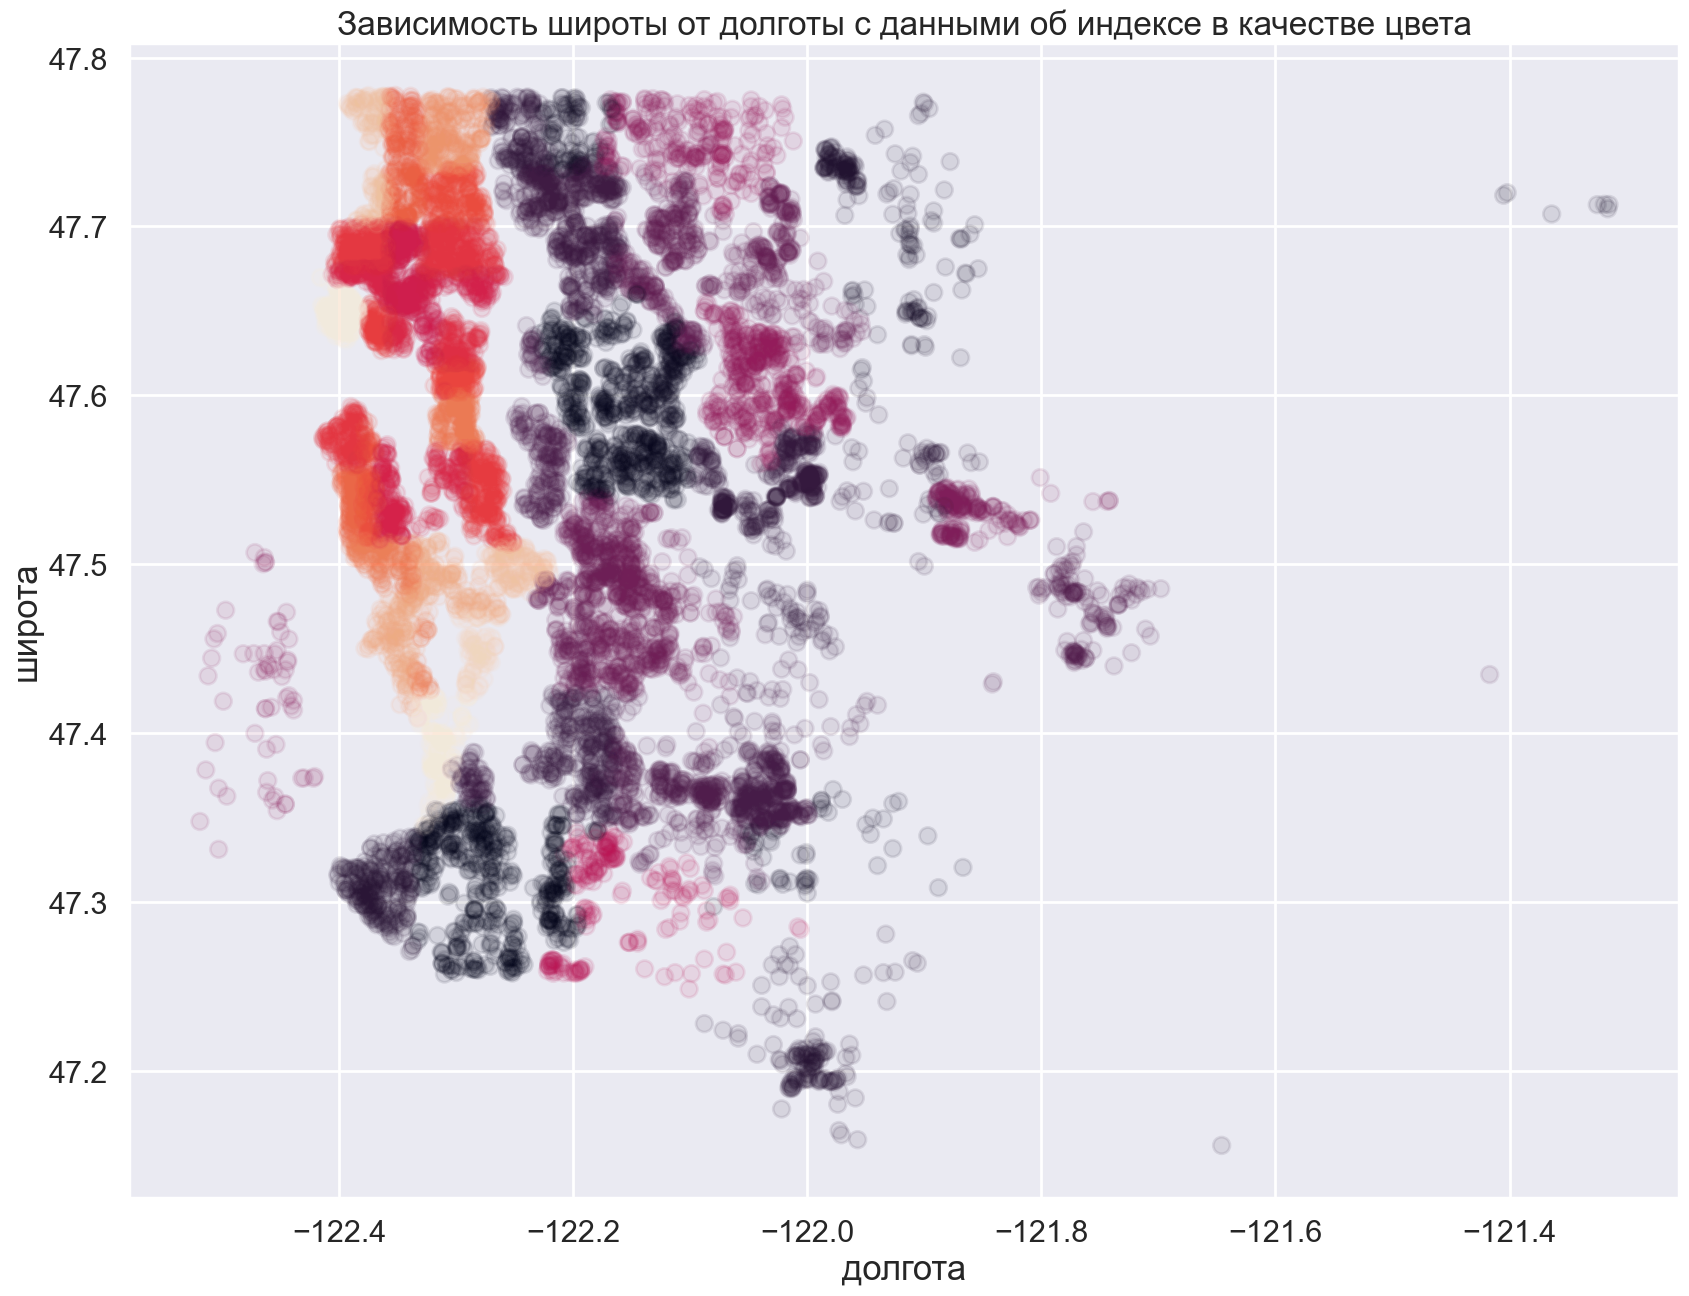

In [509]:
sns.set(context='poster')
plt.figure(figsize=(20, 15))
plt.scatter(X_train_clust['long'], X_train_clust['lat'], c=X_train_clust['zipcode'], alpha=0.1)
plt.xlabel('долгота', fontsize=25)
plt.ylabel('широта', fontsize=25)
plt.title('Зависимость широты от долготы с данными об индексе в качестве цвета');

Видим, что есть явные выбросы, но не будем их удалять, так как это ухудшает качество.

In [510]:
#y_train_clust = y_train_clust[X_train_clust['lat'] > 47.2]
#X_train_clust = X_train_clust[X_train_clust['lat'] > 47.2]

#y_train_clust = y_train_clust[X_train_clust['long'] > -122.35]
#y_train_clust = y_train_clust[X_train_clust['long'] < -121.6]
#X_train_clust = X_train_clust[X_train_clust['long'] > -122.35]
#X_train_clust = X_train_clust[X_train_clust['long'] < -121.6]

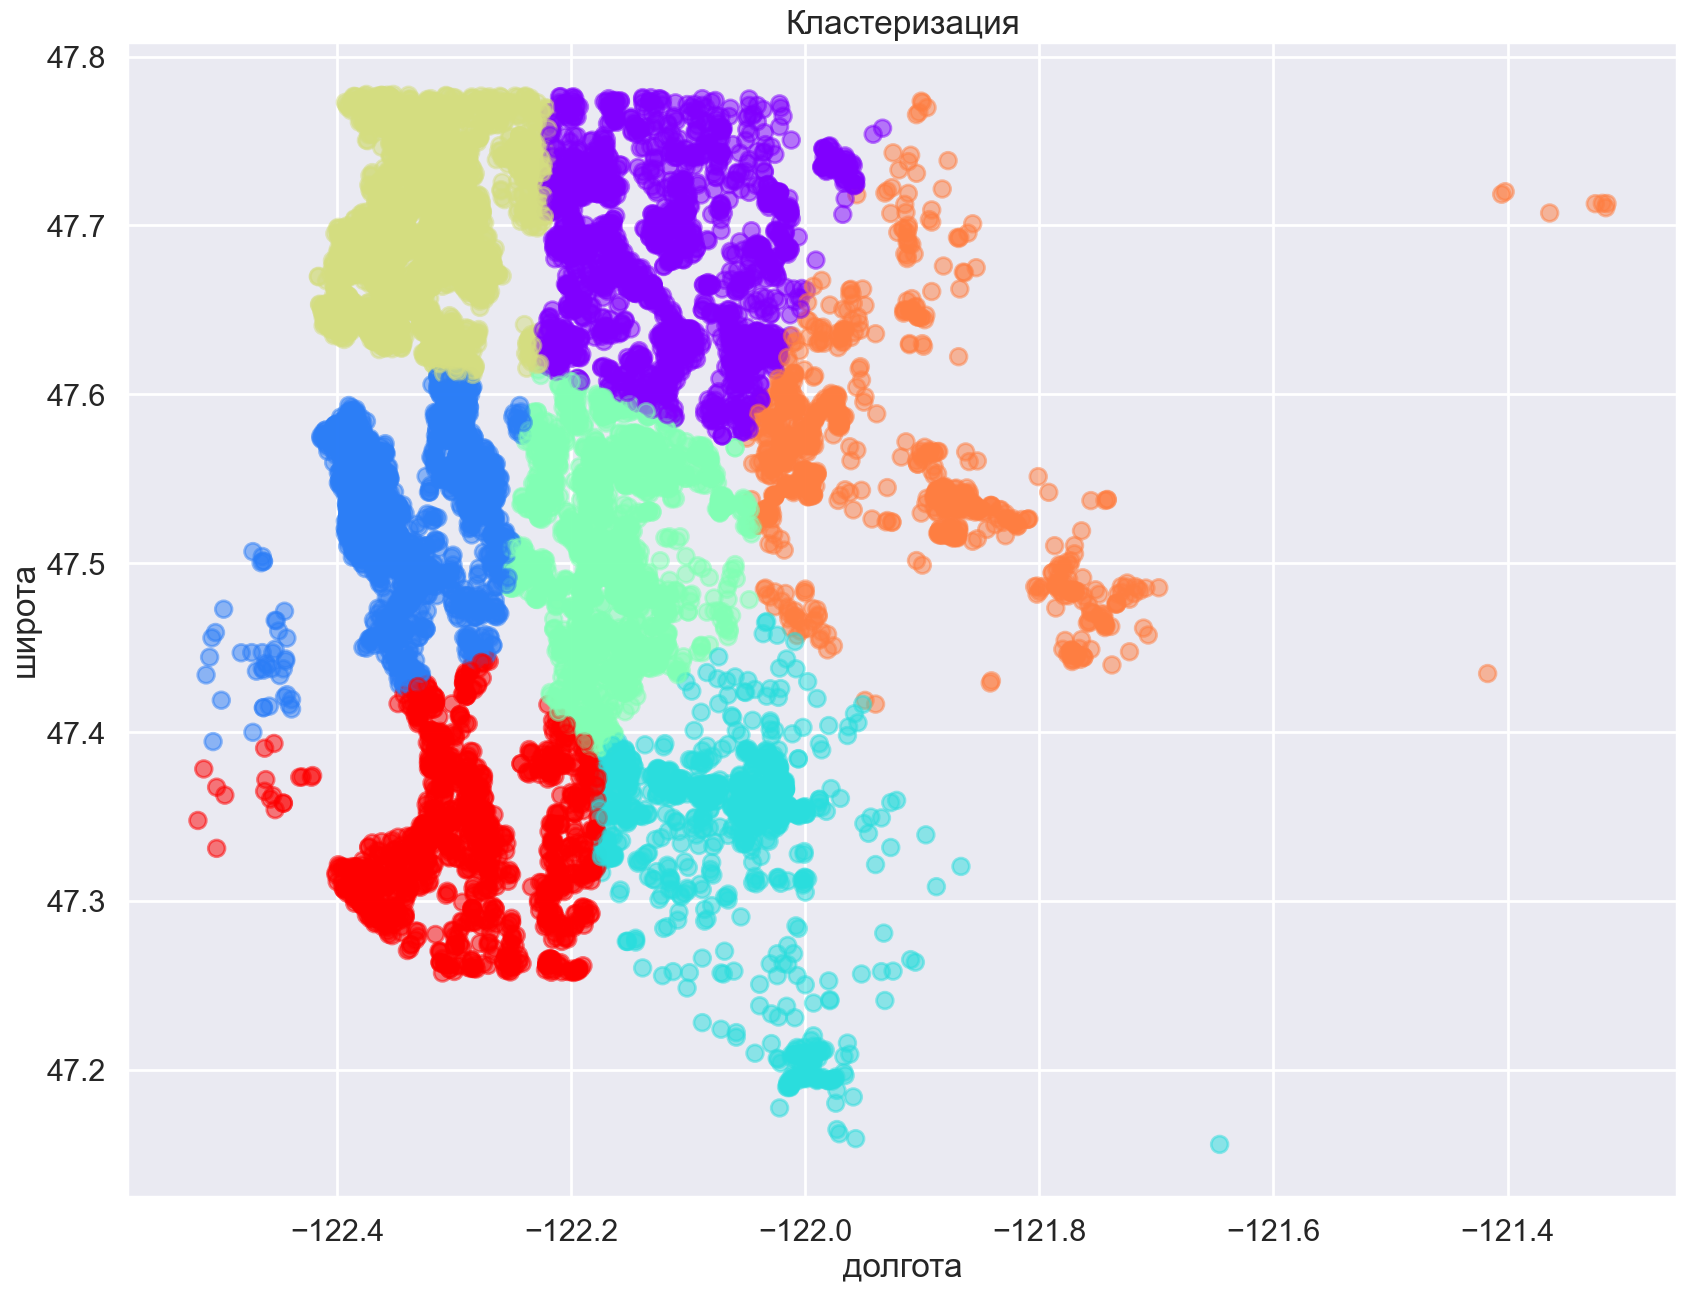

In [550]:
plt.rcParams['image.cmap'] = 'rainbow'
kmeans = KMeans(n_clusters=7, random_state=25)
kmeans.fit(X_train_clust[coordinates])
y_pred = kmeans.predict(X_train_clust[coordinates])

plt.figure(figsize=(20, 15))
plt.scatter(X_train_clust[coordinates[0]], X_train_clust[coordinates[1]], c=y_pred, alpha=0.5)
plt.xlabel('долгота')
plt.ylabel('широта')
plt.title('Кластеризация');

Я не стал рисовать много разных картинок с разным количеством кластеров, я подбирал сам и визуально оценивал насколько адекватна данная кластеризация в данном случае, мне показалось, что подобранный мною вариант достаточно хорошо кластеризовал наши данные.

Добавим номер кластера и будем считать его за категориальный признак.

In [539]:
X_train_clust['num_clust'] = y_pred
X_test_clust['num_clust'] = kmeans.predict(X_test_clust[coordinates])

Добавим расстояние от точки до центра ее кластера.

In [540]:
X_train_clust['dist_to_cent'] = np.amin(kmeans.transform(X_train_clust[coordinates]), axis=1)
X_test_clust['dist_to_cent'] = np.amin(kmeans.transform(X_test_clust[coordinates]), axis=1)

Сгруппируем средние значения всех признаков в зависимости от номера кластера.

In [541]:
mean_table_train = X_train_clust.groupby(['num_clust']).mean()
mean_table_test = X_test_clust.groupby(['num_clust']).mean()

In [542]:
mean_table_train

,timef_built,timef_renovated,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,lat,long,sqft_living15,sqft_lot15,zipcode,month,dist_to_cent,mean_sqft,mean_timef_built
num_clust,,,,,,,,,,,,,,,,,,,,,
0,33.478680,32.354822,3.571574,2.332360,2399.414213,18058.587817,1.507614,0.004569,0.144670,3.349239,...,280.739594,47.680814,-122.118246,2311.618274,15169.577665,98042.817259,6.516244,0.079307,2395.377240,32.478456
1,58.563599,54.564116,3.141675,1.834152,1719.897104,8341.132885,1.407187,0.014995,0.354705,3.366081,...,330.324199,47.532767,-122.334009,1622.225957,8139.726474,98132.836091,6.519131,0.060489,1722.778903,58.485770
2,27.278586,25.494802,3.400208,2.194127,2052.740125,32778.601871,1.557692,0.000000,0.129938,3.426195,...,115.420998,47.337860,-122.066102,2013.237006,26798.228690,98040.330561,6.437630,0.073645,2075.915778,27.854543
3,37.484061,36.039551,3.610980,2.273022,2331.629870,12781.035419,1.454250,0.011216,0.265053,3.547816,...,348.168241,47.505845,-122.165115,2233.371901,10709.337072,98045.829988,6.517710,0.062502,2321.922005,37.862685
4,58.994604,54.789882,3.214503,1.987943,1889.479258,6398.403710,1.530691,0.005059,0.247892,3.461720,...,358.706914,47.692314,-122.328038,1766.335245,6120.587521,98118.233052,6.654300,0.056572,1898.628764,58.926870
5,24.577706,23.847803,3.448017,2.429528,2456.354770,40304.699893,1.748660,0.000000,0.140407,3.146838,...,140.825295,47.557814,-121.925620,2362.333333,30100.816720,98045.634512,6.535906,0.103313,2416.324615,26.039333
6,39.948454,38.912768,3.390167,1.994251,1900.101507,12974.618557,1.364790,0.008723,0.165741,3.432990,...,224.480571,47.335661,-122.285814,1837.301348,10300.597145,98048.525773,6.559873,0.070367,1905.453953,39.760219


Добавим признак, отвечающий за среднее значение площади жилья в зависимости от номера кластера.

In [543]:
X_train_clust['mean_sqft'] = list(map(lambda x: mean_table_train['sqft_living'][x], X_train_clust['num_clust']))
X_test_clust['mean_sqft'] = list(map(lambda x: mean_table_test['sqft_living'][x], X_test_clust['num_clust']))

Также добавим признак, отвечающий за среднее значение времени с момента постройки в зависимости от номера кластера.

In [544]:
X_train_clust['mean_timef_built'] = list(map(lambda x: mean_table_train['timef_built'][x], X_train_clust['num_clust']))
X_test_clust['mean_timef_built'] = list(map(lambda x: mean_table_test['timef_built'][x], X_test_clust['num_clust']))

Обучите модель по новым признакам.

Обучим модель, которая получилась лучшей в предыдущем задании с теми же гиперпараметрами, я использовал в задаче 3.8.3.

In [561]:
res_model_cb = CatBoostRegressor(n_estimators=650, max_depth=8, learning_rate=0.109, 
                                    l2_leaf_reg=0.79, random_strength=1, random_state=25)
res_model_cb.fit(X_train_clust, y_train_clust, verbose=False, cat_features=['zipcode', 'month', 'num_clust', 'waterfront'])

In [562]:
print('MAPE на test:', mean_absolute_percentage_error(y_test, res_model_cb.predict(X_test_clust)))

MAPE на test: 0.11772897017664363


Удалось ли повысить качество? Если да, то является ли улучшение статистически значимым?

Мне удалось повысить качество модели, хоть и не намного. С добавлением новых признаков качество улучшилось на 2%. Скорее всего улучшение не является статически значиимым, так как будь там чуть другие значения параметров, то результат (при данном количестве кластеров и других уже зафиксированных) мог бы получится хуже, то есть нужно было бы опять все подбирать.

**Выводы:** В данной задаче кластеризация и на ее основе добавление новых признаков немного помогло в улучшении качества. В целом мне кажется, что в таких задачах стоит использовать кластеризацию, но нужно четко понимать данные в каком пространстве ты кластеризуешь

---

### Задача 3

Рассмотрим одну из уже классических задач машинного обучения — предсказание кредитного рейтинга клиентов кредитной организации. В данной задаче вам нужно провести анализ данных, построить классификатор клиентов и отправить свои предсказания в Kaggle-соревнование.

Кредитный скоринг — система оценки кредитоспособности (кредитных рисков) потенциальных и действующих клиентов, в основу которой вкладываются статистические данные. Кредитный скоринг широко используется как крупными банками, микрофинансовыми организациями, так и в потребительском (магазинном) экспресс-кредитовании на небольшие суммы. Также возможно его использование в бизнесе сотовых операторов, страховых компаний и т. д. Скоринг заключается в присвоении баллов по заполнению некой анкеты, разработанной оценщиками кредитных рисков андеррайтерами. По результатам набранных баллов системой автоматически принимается решение об одобрении или отказе в выдаче кредита.

Описание данных:
* `client_id`: уникальный идентификатор клиента;
* `month`: месяц сбора информации;
* `age`: возраст клиента;
* `occupation`: вид деятельность;
* `annual_income`: годовой доход;
* `monthly_salary`: зарплата за текущий месяц;
* `number_bank_accounts`: количество банковских счетов у данного клиента;
* `number_credit_cards`: количество кредитных карт у данного клиента;
* `interest_rate`: процентная ставка по кредитной карте;
* `number_loan`: количество кредитов, взятых в банке;
* `delay_from_due_date`: среднее количество дней задержки выплат по кредиту;
* `number_delayed_payment`: количество платежей по кредиту, которые были выполнены с задержкой;
* `number_credit_inquiries`: количество запросов по кредиту;
* `unpaid_debt`: сумма долга;
* `credit_utilization_ratio`: коэффициент использования кредитных карт;
* `credit_history_age`: размер кредитной истории;
* `min_amount_payment`: была ли произведенная выплата минимально возможной;
* `monthy_amount_invested`: сумма инвестиций за месяц;
* `client_behaviour`: платежное поведение клиента;
* `monthly_balance`: баланс по итогу месяца;
* `credit_rating`: кредитный рейтинг — это **целевой признак**.

Ссылка: https://www.kaggle.com/competitions/ds-2022-autumn-39/overview

Инвайт: https://www.kaggle.com/t/6c00aded7dfc4cf181c3727b2ca995bf

**Правила**

* В Kaggle в данное тренировочное соревнование можно отправлять не более 7 решений в день (8-ю система не позволит).
* Решения индивидуальные.
* Качество считается по метрике Accuracy.
* До окончания соревнования доступны значения качества, посчитанные только на случайных 30% тестовых данных. Значения отображаются в Public Leaderboard.
* После окончания соревнования становится доступным Private Leaderboard, в котором значения качества посчитанны на оставшихся 70% объектов.
* Для включения в Private Leaderboard можно выбрать две посылки. Если будет необходимость перевода соревнования в Яндекс.Контест, то только одну, причем она должна быть последней.
* В Leaderboard должны отображаться ваши **реальные имя и фамилия**. В противном случае решение может быть не зачтено.
* Все файлы, которые вы отправляете в соревнование, видны организаторам соревнования. Файлы должны иметь понятное имя, при отправке файла в систему необходимо написать краткое описание решения. **Это будет проверяться.**
* В решении, отправляемом боту, должно быть отображено, результаты каких моделей вы отправляете в соревнование.
* Не забывайте сделать пояснения к своему решению. **Решение может быть не зачтено, если в нем недостаточно пояснений**, даже если удалось попасть в топ-3.
* Пользоваться можно любыми пройденными в наших курсах моделями.
* Код студентов, занявших первые 3 места, будет запускаться. Также выборочно может запускаться код и остальных студентов.

**Советы**

* Чтобы получить действительно хороший результат подбора гиперпараметров мало, попробуйте ввести новые признаки для улучшения качества решения.
* Некоторые инсайты по тому, какие признаки могут улучшить качество, можно получить если провести разведывательный анализ данных (EDA). Например, может иметь смысл изучить датасет на предмет наличия выбросов, исследовать пространственное и временное распределение отклика. 
* Изучите различные методы, предложенные на занятиях.

**Баллы**

* **Выдаются только при соблюдении всех правил** и суммируются.
* 10 баллов — ваше решение лучше sample_submission.csv на Private Leaderboard.
* по 15 баллов — за каждый следующий преодоленный порог на Private Leaderboard, пороги: 55%, 65%, 75%, 85%.
* 20 баллов за попадание в топ-3 на Private Leaderboard.
* 1 конфета — попадание в топ-10 на Private Leaderboard.
* 1 средняя конфета — попадание в топ-3 на Private Leaderboard.
* 1 большая конфета — попадание в топ-1 на Private Leaderboard.
* небольшие декоративные фигурки за топ-1 на Private Leaderboard, за наиболее хорошо оформленное решение, за самую оригинальную идею (которая привела к улучшению).

In [926]:
df_train = pd.read_csv('ds-2022-autumn-39/train.csv')
df_test = pd.read_csv('ds-2022-autumn-39/test.csv')

In [927]:
df_train.head()

,client_id,month,age,occupation,annual_income,monthly_salary,number_bank_accounts,number_credit_cards,interest_rate,number_loan,...,number_delayed_payment,number_credit_inquiries,unpaid_debt,credit_utilization_ratio,credit_history_age,min_amount_payment,monthy_amount_invested,client_behaviour,monthly_balance,credit_rating
0,5e261a2ce0,Февраль,NaN,NaN,34811.50,2977.666667,2,4,6.0,1.0,...,4.0,2.0,605.03,24.464031,26 г. 7 м.,No,104.291825,"Малые траты, малые платежи",463.220627,Обычный
1,5e261a2ce0,Март,28.0,Учитель,34231.28,2991.866667,2,4,6.0,1.0,...,1.0,2.0,605.03,38.550848,26 г. 8 м.,No,40.391238,"Большие траты, большие платежи",478.941214,Хороший
2,5e261a2ce0,Апрель,28.0,Учитель,NaN,2979.906667,2,1385,6.0,1.0,...,NaN,2.0,605.03,33.224951,26 г. 9 м.,No,58.515976,"Большие траты, большие платежи",464.256476,Обычный
3,5e261a2ce0,Май,28.0,Учитель,34376.73,NaN,2,4,6.0,1.0,...,NaN,2.0,605.03,39.182656,26 г. 10 м.,No,99.306228,"Малые траты, средние платежи",457.656224,Хороший
4,5e261a2ce0,Июнь,28.0,Учитель,34415.88,2958.436667,2,4,6.0,1.0,...,1.0,2.0,605.03,34.977895,26 г. 11 м.,No,130.115420,"Малые траты, малые платежи",443.497032,Хороший


In [928]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   client_id                 64000 non-null  object 
 1   month                     64000 non-null  object 
 2   age                       59135 non-null  float64
 3   occupation                59459 non-null  object 
 4   annual_income             59531 non-null  float64
 5   monthly_salary            54401 non-null  float64
 6   number_bank_accounts      64000 non-null  int64  
 7   number_credit_cards       64000 non-null  int64  
 8   interest_rate             61720 non-null  float64
 9   number_loan               58215 non-null  float64
 10  delay_from_due_date       64000 non-null  int64  
 11  number_delayed_payment    56849 non-null  float64
 12  number_credit_inquiries   61489 non-null  float64
 13  unpaid_debt               63358 non-null  float64
 14  credit

Найдем вещественные и категориальные признаки.

In [929]:
real_features = [name for name, dtype in df_train.dtypes.items() if dtype != 'object' and dtype != 'str']
cat_features = [name for name, dtype in df_train.dtypes.items() if dtype == 'object' and name != 'client_id' and
               name != 'credit_rating']

Посмотрим на распределения вещественных признаков.

  0%|          | 0/14 [00:00<?, ?it/s]

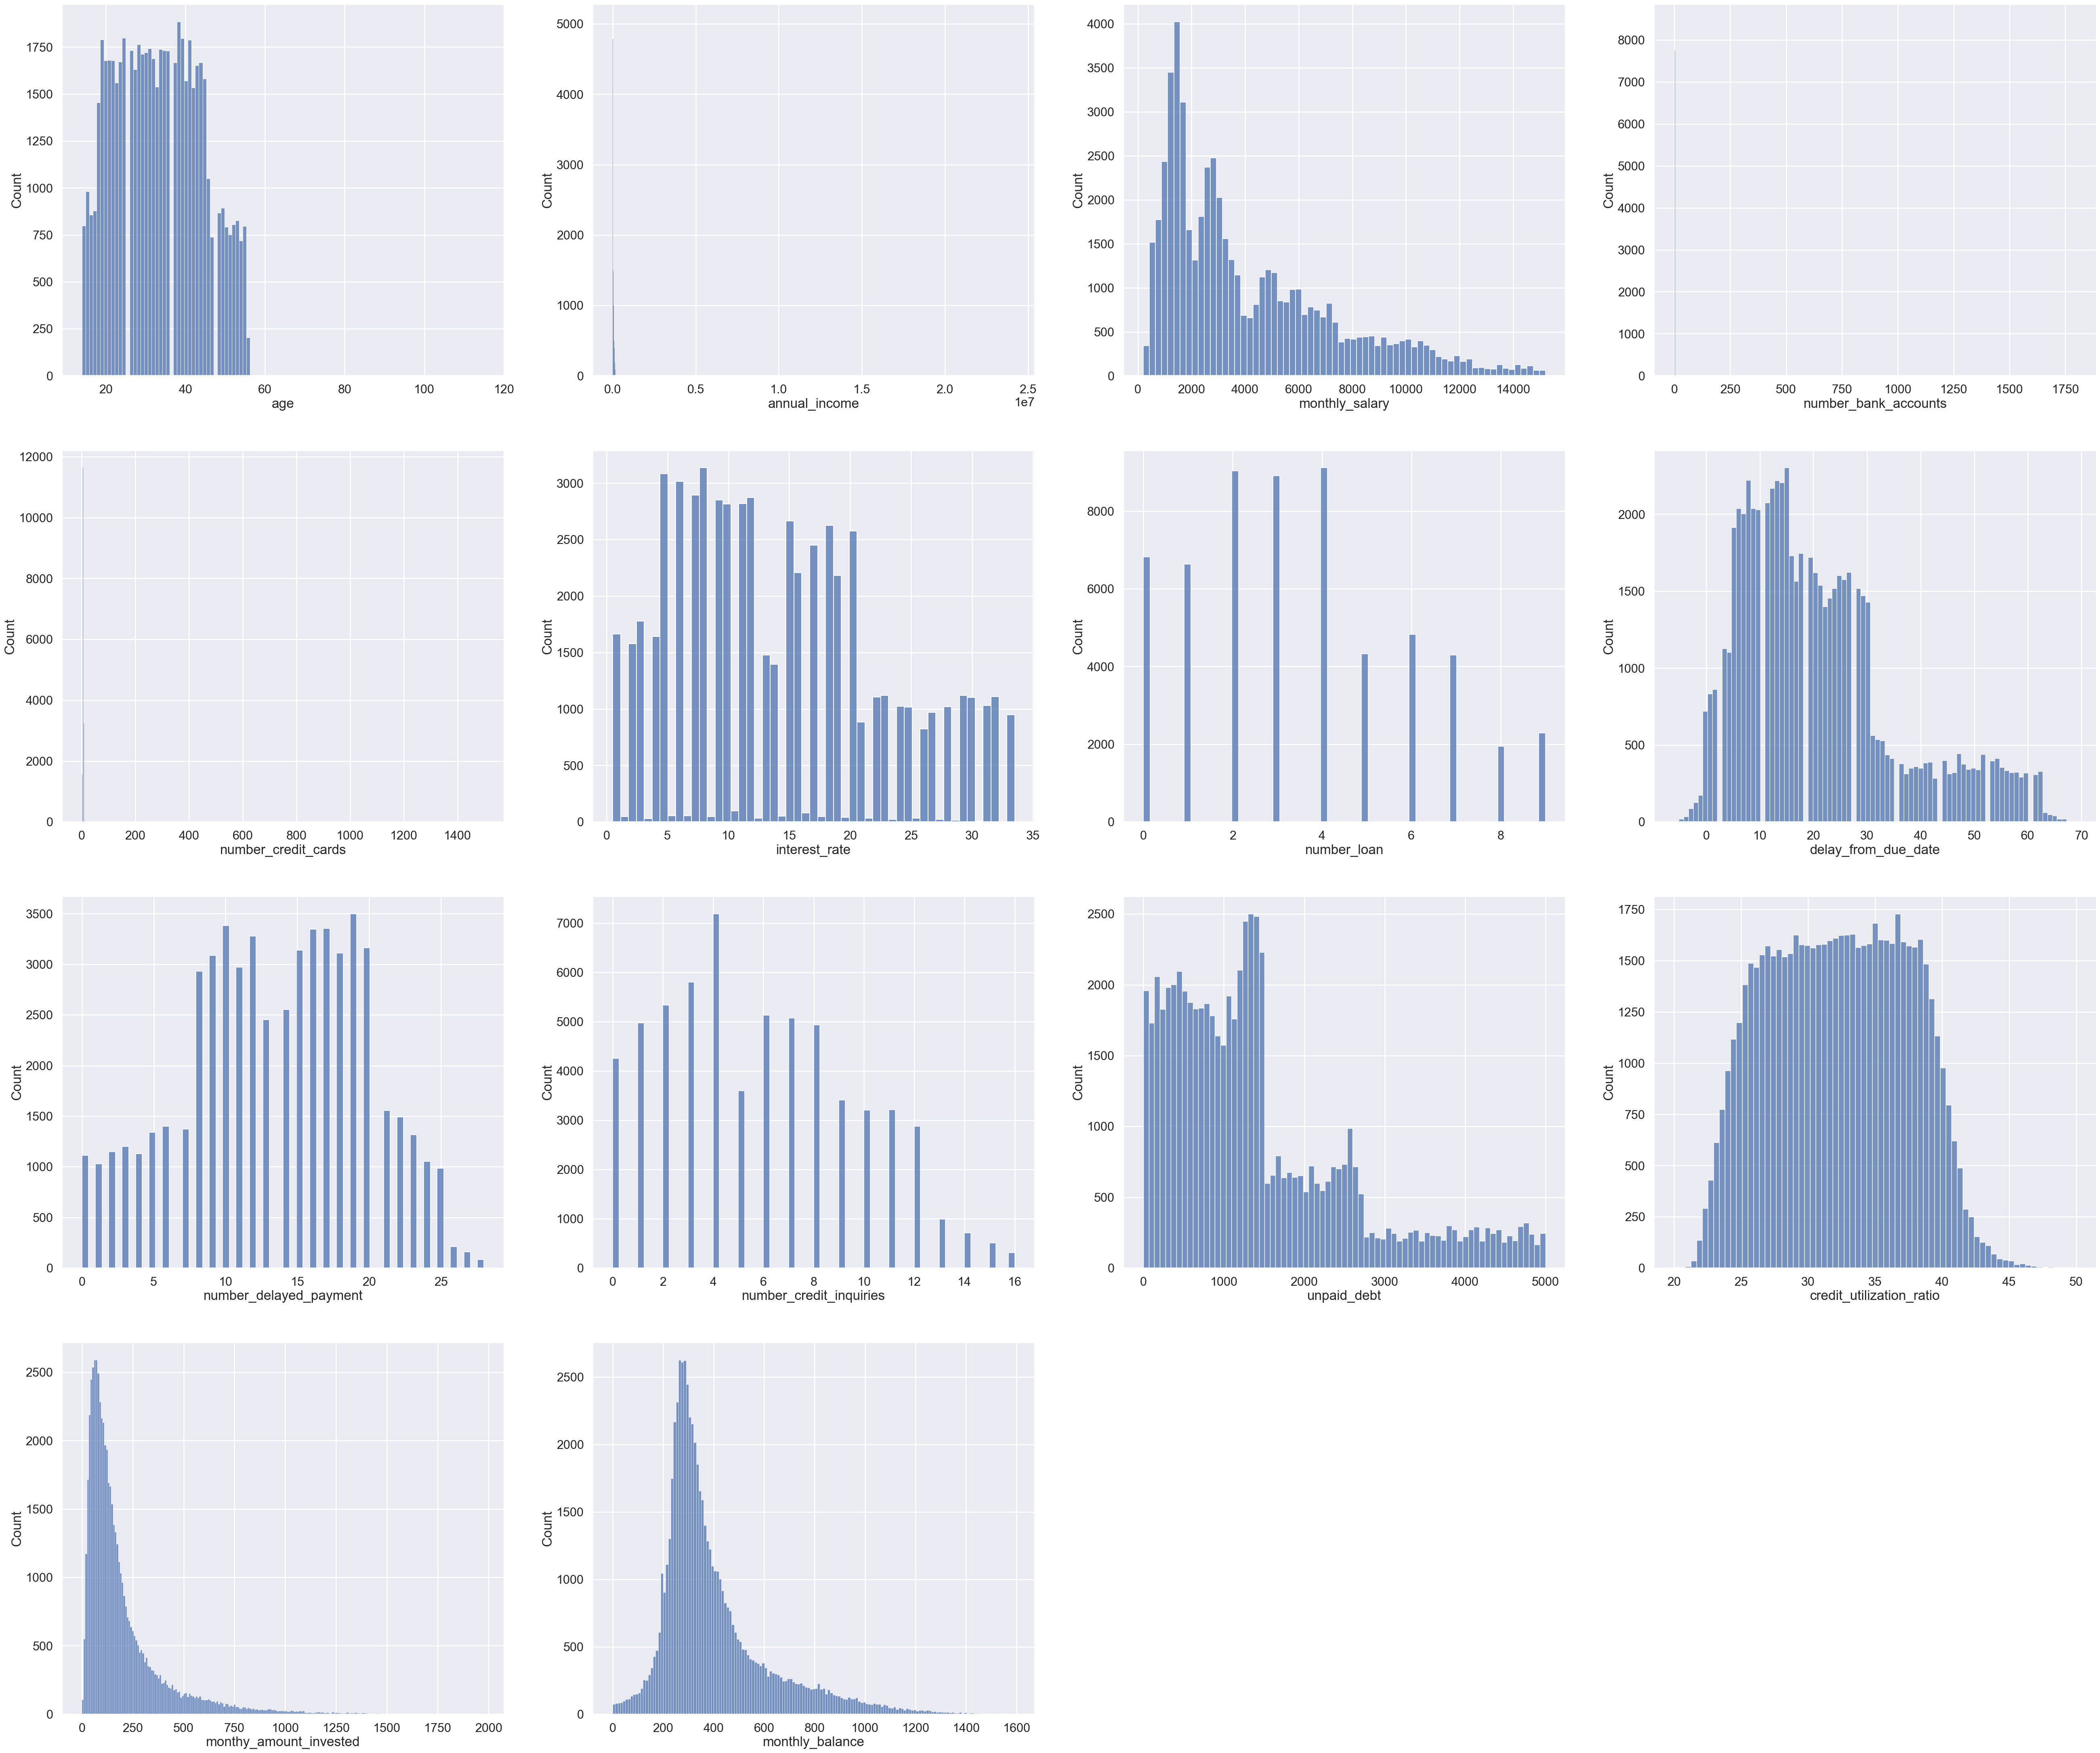

In [930]:
plt.figure(figsize=(65, 55))
for i in tqdm(range(len(real_features))):
    plt.subplot(4, 4, i + 1)
    sns.histplot(df_train[real_features[i]])

Видно, что на некоторых гистограммах распреление сильно смещено влево (например: annual_income, number_bank_accounts, number_credit_cards, monthy_amount_invested). Возьмем логарифм от данных признаков.

In [931]:
df_train['annual_income'] = np.log(df_train['annual_income'] + 1)
df_test['annual_income'] = np.log(df_test['annual_income'] + 1)

df_train['number_bank_accounts'] = np.log(df_train['number_bank_accounts'] + 1)
df_test['number_bank_accounts'] = np.log(df_test['number_bank_accounts'] + 1)

df_train['number_credit_cards'] = np.log(df_train['number_credit_cards'] + 1)
df_test['number_credit_cards'] = np.log(df_test['number_credit_cards'] + 1)

df_train['monthy_amount_invested'] = np.log(df_train['monthy_amount_invested'] + 1)
df_test['monthy_amount_invested'] = np.log(df_test['monthy_amount_invested'] + 1)

df_train['monthly_balance'] = np.sqrt(df_train['monthly_balance'] + 1)
df_test['monthly_balance'] = np.sqrt(df_test['monthly_balance'] + 1)

Добавим числовой признак, отвечающий за размер кредитной истории в месяцах.

In [932]:
df_train['credit_history_age_value'] = df_train['credit_history_age'].apply(lambda x: int(x.split()[0]) * 12 + \
                                        int(x.split()[2]) if x is not np.nan else x)
df_test['credit_history_age_value'] = df_test['credit_history_age'].apply(lambda x: int(x.split()[0]) * 12 + \
                                        int(x.split()[2]) if x is not np.nan else x)
real_features.append('credit_history_age_value')

Посмотрим как распределен таргет.

In [933]:
df_train['credit_rating'].value_counts()

Обычный    33520
Плохой     18771
Хороший    11709
Name: credit_rating, dtype: int64

Видим, что отклики распределены не совсем равномерно, но и не очень плохо.

Введем новые признаки: sum_interest_rate - суммарная процентная ставка по кредитным картам, agree_loan - часть одобренных кредитов, sum_delay_days - общее количество дней, на которое человек задержал платеж (в среднем), time_pay_debt - сколько лет нужно для погашения долга (если годовую зарплату считать постоянной), coef - перемножили коэффициент использования и величины, относящиеся к кредитным картам.

In [934]:
df_train['sum_interest_rate'] = df_train['interest_rate'] * df_train['number_credit_cards']
df_test['sum_interest_rate'] = df_test['interest_rate'] * df_test['number_credit_cards']

df_train['agree_loan'] = df_train['number_loan'] / np.maximum(df_train['number_credit_inquiries'], 1)
df_test['agree_loan'] = df_test['number_loan'] / np.maximum(df_test['number_credit_inquiries'], 1)

df_train['sum_delay_days'] = df_train['delay_from_due_date'] * df_train['number_delayed_payment']
df_test['sum_delay_days'] = df_test['delay_from_due_date'] * df_test['number_delayed_payment']

df_train['time_pay_debt'] = df_train['unpaid_debt'] / df_train['annual_income']
df_test['time_pay_debt'] = df_test['unpaid_debt'] / df_test['annual_income']

df_train['coef'] = df_train['credit_utilization_ratio'] * df_train['credit_history_age_value'] * df_train['number_credit_cards']
df_test['coef'] = df_test['credit_utilization_ratio'] * df_test['credit_history_age_value'] * df_test['number_credit_cards']

In [935]:
real_features.append('sum_interest_rate')
real_features.append('agree_loan')
real_features.append('sum_delay_days')
real_features.append('time_pay_debt')
real_features.append('coef')

In [936]:
feature_names = real_features + cat_features
test_name = 'credit_rating'

Разделим выборку на обучающую и валидационную.

In [937]:
x_train, x_valid, y_train, y_valid = train_test_split(df_train[feature_names], df_train[test_name], test_size=0.25, 
                                                     random_state=25)
x_test = df_test[feature_names]

Посчитаем средний возраст людей в зависимости от того, сколько кредитов у них есть.

In [938]:
mean_age_train = x_train.groupby(['number_loan']).mean()['age']
mean_age_valid = x_valid.groupby(['number_loan']).mean()['age']
mean_age_test = x_test.groupby(['number_loan']).mean()['age']

x_train['age_loan'] = list(map(lambda x: np.nan if math.isnan(x) else mean_age_train[x], x_train['number_loan']))
x_valid['age_loan'] = list(map(lambda x: np.nan if math.isnan(x) else mean_age_valid[x], x_valid['number_loan']))
x_test['age_loan'] = list(map(lambda x: np.nan if math.isnan(x) else mean_age_test[x], x_test['number_loan']))

real_features.append('age_loan')
feature_names = real_features + cat_features

Закодируем таргеты.

In [939]:
encoder_target = LabelEncoder()
y_train = encoder_target.fit_transform(y_train)

Приведем категориальные признаки к строковому типу, чтобы CatBoost смог их обработать.

In [940]:
x_train[cat_features] = x_train[cat_features].astype(str)
x_valid[cat_features] = x_valid[cat_features].astype(str)
x_test[cat_features] = x_test[cat_features].astype(str)

Обучим модель CatBoost, так как у нас много категориальных признаков и в предыдущей задаче CatBoost давал лучший результат.

In [909]:
n_estimators = 800
model_cb_1 = CatBoostClassifier(n_estimators=n_estimators, random_state=25)
model_cb_1.fit(x_train, y_train, cat_features=cat_features, verbose=False)

In [910]:
predicts = model_cb_1.predict(x_valid)
y_predicts = encoder_target.inverse_transform(predicts)
accuracy_score(y_valid, y_predicts) # точность

0.719125

Сейчас пройдемся по сетке и найдем наилучшие параметры.

In [807]:
model_cb = CatBoostClassifier(cat_features=cat_features, random_state=25)

In [808]:
parameters_grid = {
    'n_estimators' : np.arange(50, 500, 10),
    'max_depth' : range(1, 10, 1),
    'l2_leaf_reg' : sps.expon(loc=0, scale=1),
    'learning_rate' : np.linspace(0.001, 0.4, 1000)
}

ss = StratifiedKFold(n_splits=5)

rs_cb = RandomizedSearchCV(
    # модель для обучения, в нашем случае XGBoostClassifier
    estimator=model_cb,
    # количество итераций поиска 
    n_iter=50,
    # сетка значений гиперпараметров
    param_distributions=parameters_grid,
    # метрика качества, берем accuracy
    scoring='accuracy',
    # GridSearch отлично параллелится, но и XGBoost параллелится
    n_jobs=-2,  
    # стратегия кросс-валидации
    cv=ss,  
     # сообщения с логами обучения: больше значение - больше сообщений
    verbose=1, 
    # значение, присваиваемое scorer в случае ошибки при обучении
    error_score='raise',
    # seed для генератора случайных чисел
    random_state=25
)

In [810]:
rs_cb.fit(x_train, y_train, verbose=False)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   error_score='raise',
                   estimator=<catboost.core.CatBoostClassifier object at 0x7fbbb5f18400>,
                   n_iter=50, n_jobs=-2,
                   param_distributions={'l2_leaf_reg': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fbbb5eec760>,
                                        'learning_rate': array([0.001     , 0.0013994 , 0.001798...
       0.39640541, 0.3968048 , 0.3972042 , 0.3976036 , 0.398003  ,
       0.3984024 , 0.3988018 , 0.3992012 , 0.3996006 , 0.4       ]),
                                        'max_depth': range(1, 10),
                                        'n_estimators': array([ 50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160, 170,
       180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300,
       310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430,
       440, 450, 460, 470, 480,

In [811]:
rs_cb.best_params_

{'l2_leaf_reg': 0.5294991062588612,
 'learning_rate': 0.3065405405405406,
 'max_depth': 9,
 'n_estimators': 330}

In [831]:
predicts_cb = rs_cb.predict(x_valid)
y_predicts_cb = encoder_target.inverse_transform(predicts_cb)
accuracy_score(y_valid, y_predicts_cb)

0.72125

Посмотрим график зависимости accuracy от количества деревьев.

In [857]:
n_estimators_grid = np.arange(1, 1500)

classifier_cb = CatBoostClassifier(n_estimators=max(n_estimators_grid), silent=True)
classifier_cb.fit(x_train, y_train, verbose=False, cat_features=cat_features)

acc_train = []
acc_valid = []
for i in tqdm(range(1, 1500)):
    acc_train.append(accuracy_score(y_train, classifier_cb.predict(x_train, ntree_end=i)))
    acc_valid.append(accuracy_score(y_valid, encoder_target.inverse_transform(classifier_cb.predict(x_valid, ntree_end=i))))

  0%|          | 0/1499 [00:00<?, ?it/s]

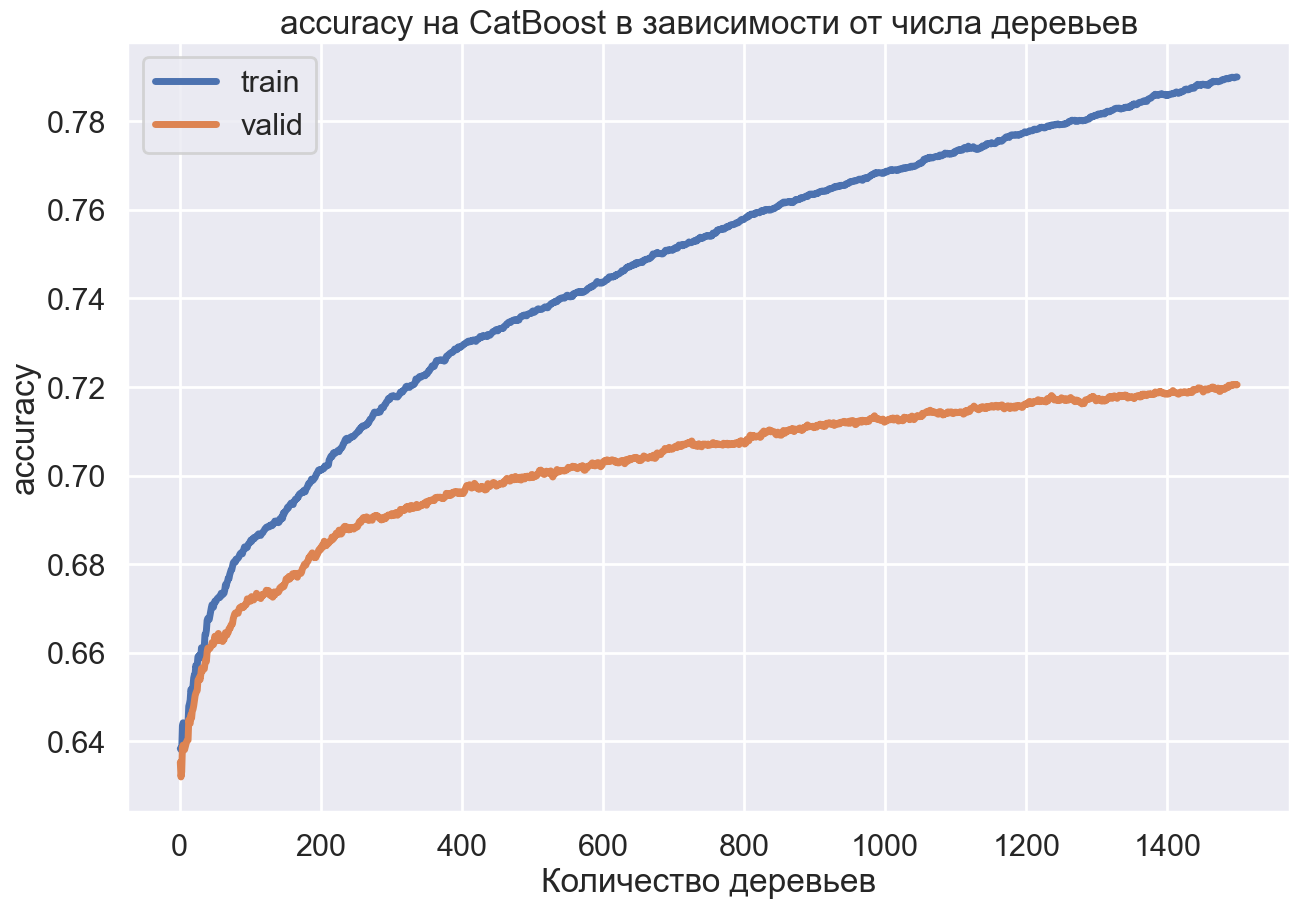

In [859]:
plt.figure(figsize=(15, 10))
plt.plot(n_estimators_grid, acc_train, lw=5, label='train')
plt.plot(n_estimators_grid, acc_valid, lw=5, label='valid')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('Количество деревьев')
plt.title('accuracy на CatBoost в зависимости от числа деревьев');

На графике видно, что обе величины довольно быстро растут, но логично, что быстрее растет точность на обучающей выборке.

Сейчас посмотрим на то, какое качество даст LGBM. Для этого сделаем MeanEncoding, чтобы LightGBM мог обрабатывать категориальные признаки.

In [865]:
x_train_enc = x_train.copy()
x_valid_enc = x_valid.copy()
x_test_enc = x_test.copy()

In [866]:
x_train_enc[cat_features] = x_train_enc[cat_features].astype(object)
x_valid_enc[cat_features] = x_valid_enc[cat_features].astype(object)
x_test_enc[cat_features] = x_test_enc[cat_features].astype(object)

In [869]:
encoder_mean = TargetEncoder(cols=cat_features)
x_train_enc = encoder_mean.fit_transform(x_train_enc, y_train)
x_valid_enc = encoder_mean.transform(x_valid_enc, y_valid)
x_test_enc = encoder_mean.transform(x_test)

In [886]:
x_train_enc

,age,annual_income,monthly_salary,number_bank_accounts,number_credit_cards,interest_rate,number_loan,delay_from_due_date,number_delayed_payment,number_credit_inquiries,...,agree_loan,sum_delay_days,time_pay_debt,coef,month,occupation,credit_history_age,min_amount_payment,client_behaviour,age_loan
35360,39.0,11.103264,5376.838333,1.386294,1.945910,15.0,0.0,30,19.0,NaN,...,NaN,570.0,49.957382,16757.099736,0.610043,0.671351,0.840909,0.482373,0.654668,36.307126
12348,36.0,10.359025,NaN,1.791759,1.386294,20.0,2.0,21,18.0,5.0,...,0.400000,378.0,48.943796,15938.530414,0.674526,0.671351,0.683333,0.678067,0.654668,33.699188
920,15.0,9.188138,622.434167,1.945910,2.079442,30.0,5.0,54,NaN,NaN,...,NaN,NaN,227.055805,NaN,0.610043,0.605301,0.653057,0.482373,0.687777,29.675320
49965,54.0,9.750715,1605.823333,0.693147,1.945910,10.0,3.0,15,7.0,1.0,...,3.000000,105.0,134.175808,25308.252184,0.682038,0.649269,0.716981,0.910895,0.661088,34.694309
46765,53.0,10.991381,5190.787500,2.079442,2.079442,17.0,3.0,28,NaN,1.0,...,3.000000,NaN,117.718599,22764.368409,0.682038,0.649165,0.731959,0.678067,0.658741,34.694309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35702,37.0,9.750139,1538.539167,2.197225,2.197225,23.0,9.0,47,16.0,11.0,...,0.818182,752.0,153.853194,6207.251853,0.690448,0.605301,0.628571,0.678067,0.662707,29.444304
26767,22.0,9.518462,1309.893333,2.079442,2.397895,25.0,9.0,43,20.0,6.0,...,1.500000,860.0,466.986176,8093.308368,0.692091,0.641720,0.462366,0.482373,0.632019,29.444304
6618,28.0,9.684894,1349.579167,2.397895,1.791759,16.0,7.0,43,16.0,7.0,...,1.000000,688.0,396.820027,1322.376160,0.619627,0.717717,0.500000,0.482373,0.632019,29.600802
24894,39.0,9.177980,NaN,1.945910,2.197225,23.0,9.0,52,25.0,9.0,...,1.000000,1300.0,194.113511,10022.412781,0.690448,0.671690,0.560440,0.482373,0.632019,29.444304


Обучим модель и просто посмотрим на значение ошибки, так будет легче отрисовывать графики.

In [899]:
n_estimators = 800
model_lgbm_1 = lgb.LGBMClassifier(n_estimators=n_estimators, random_state=25)
model_lgbm_1.fit(x_train_enc, y_train, verbose=False, categorical_feature=cat_features)

LGBMClassifier(n_estimators=800, random_state=25)

In [900]:
predicts_lgbm = model_lgbm_1.predict(x_valid_enc)
y_predicts_lgbm = encoder_target.inverse_transform(predicts_lgbm)
accuracy_score(y_valid, y_predicts_lgbm)

0.7560625

Также пройдемся по сетке.

In [944]:
model_lgbm = RandomizedSearchCV(
    estimator=lgb.LGBMClassifier(random_state=25), 
    param_distributions={
        'max_depth': np.arange(3, 9), 
        'n_estimators': np.arange(50, 500, 10),
        'learning_rate': np.linspace(0.05, 0.4, 1000)
    },
    cv=5, 
    verbose=1, 
    n_jobs=-2, 
    n_iter=35, 
    random_state=25
)

In [945]:
model_lgbm.fit(x_train_enc, y_train)

Fitting 5 folds for each of 35 candidates, totalling 175 fits


RandomizedSearchCV(cv=5, estimator=LGBMClassifier(random_state=25), n_iter=35,
                   n_jobs=-2,
                   param_distributions={'learning_rate': array([0.05      , 0.05035035, 0.0507007 , 0.05105105, 0.0514014 ,
       0.05175175, 0.0521021 , 0.05245245, 0.0528028 , 0.05315315,
       0.0535035 , 0.05385385, 0.0542042 , 0.05455455, 0.0549049 ,
       0.05525526, 0.05560561, 0.05595596, 0.05630631, 0.05665666,
       0.05700701, 0....
       0.39684685, 0.3971972 , 0.39754755, 0.3978979 , 0.39824825,
       0.3985986 , 0.39894895, 0.3992993 , 0.39964965, 0.4       ]),
                                        'max_depth': array([3, 4, 5, 6, 7, 8]),
                                        'n_estimators': array([ 50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160, 170,
       180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300,
       310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430,
       440, 450, 460, 470, 480, 490])},
             

In [946]:
model_lgbm.best_params_

{'n_estimators': 480, 'max_depth': 8, 'learning_rate': 0.3817817817817818}

In [947]:
predicts_lgbm = model_lgbm.predict(x_valid_enc)
y_predicts_lgbm = encoder_target.inverse_transform(predicts_lgbm)
accuracy_score(y_valid, y_predicts_lgbm)

0.7320625

In [905]:
n_estimators_grid = np.arange(1, 1500)

classifier_lgbm = lgb.LGBMClassifier(n_estimators=max(n_estimators_grid), silent=True)
classifier_lgbm.fit(x_train_enc, y_train, verbose=False, categorical_feature=cat_features)

acc_train_lgbm = []
acc_valid_lgbm = []
for i in tqdm(range(1, 1500)):
    acc_train_lgbm.append(accuracy_score(y_train, classifier_lgbm.predict(x_train_enc, num_iteration=i)))
    acc_valid_lgbm.append(accuracy_score(y_valid, encoder_target.inverse_transform(classifier_lgbm.predict(x_valid_enc, num_iteration=i))))

  0%|          | 0/1499 [00:00<?, ?it/s]

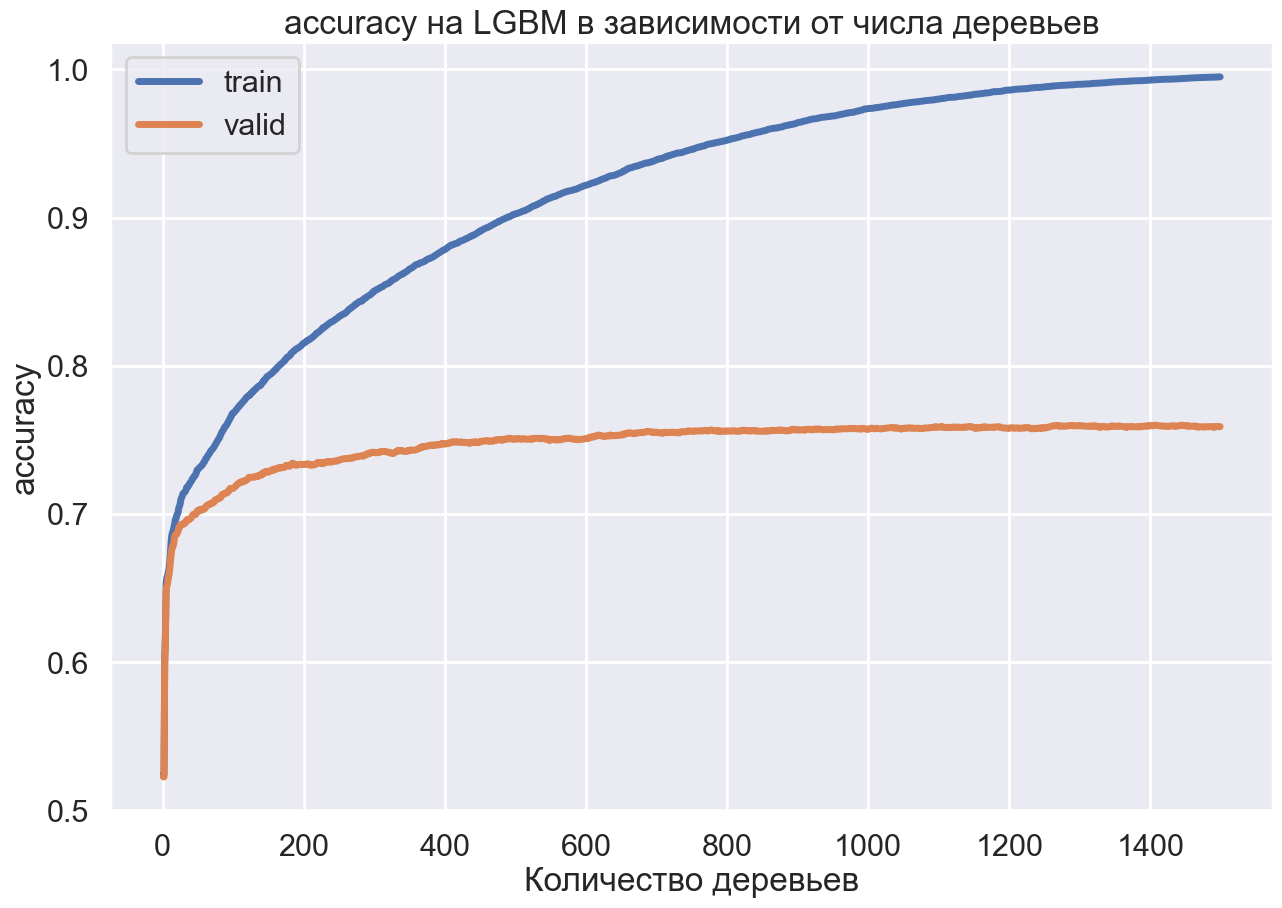

In [908]:
plt.figure(figsize=(15, 10))
plt.plot(n_estimators_grid, acc_train_lgbm, lw=5, label='train')
plt.plot(n_estimators_grid, acc_valid_lgbm, lw=5, label='valid')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('Количество деревьев')
plt.title('accuracy на LGBM в зависимости от числа деревьев');

На данном же графике видно, что точность на валидации также как и в предыдщем заметно меньше, чем на обучающей, но сходится значение точности здеь быстрее. Также само значение точности здесь лучше.

Исходя из графиков и сеток подберем лучшие гиперпараметры для модели LGBM.

In [794]:
sample = pd.read_csv('ds-2022-autumn-39/sample_submission.csv')
indexes = sample['index']

In [968]:
model_lgbm_res = lgb.LGBMClassifier(n_estimators=3000, max_depth=8, learning_rate=0.3817, random_state=25)
model_lgbm_res.fit(x_train_enc, y_train, categorical_feature=cat_features)
accuracy_score(y_valid, encoder_target.inverse_transform(model_lgbm_res.predict(x_valid_enc)))

0.760375

In [969]:
model_lgbm_res = lgb.LGBMClassifier(n_estimators=3500, max_depth=8, learning_rate=0.3817, random_state=25)
model_lgbm_res.fit(x_train_enc, y_train, categorical_feature=cat_features)
predictions_test_2 = model_lgbm_res.predict(x_test_enc)
predictions_test_2 = encoder_target.inverse_transform(predictions_test_2)
data_predicts_2 = pd.DataFrame(indexes, columns=['index'])
data_predicts_2['credit_rating'] = predictions_test_2
data_predicts_2

,index,credit_rating
0,0,Хороший
1,1,Обычный
2,2,Хороший
3,3,Хороший
4,4,Хороший
...,...,...
35995,99995,Обычный
35996,99996,Обычный
35997,99997,Обычный
35998,99998,Обычный


In [ ]:
predictions_test_1 = model_cb.predict(x_test)
predictions_test_1 = encoder_target.inverse_transform(predictions_test_1)
data_predicts_1 = pd.DataFrame(indexes, columns=['index'])
data_predicts_1['credit_rating'] = predictions_test_1
data_predicts_1

In [970]:
data_predicts_2.to_csv('credit_rating_2.csv', index=False)

**Выводы:** Я рассмотрел две модели градиентного бустинга для решения данной задачи. В данной задаче LGBM давал в среднем результаты лучше чем CatBoost. До применения моделей я также провел работу с признаками, добавил много новых признаков и немного менял существующие. На валидации точность была равна 0.7519 в случае LGBM, что, как мне кажется, довольно хороший результат.